# Loading of TERN DroneScape imagery data with pySTAC and odc-stac

* Catalog: https://data.tern.org.au/uas/dronescape/catalog.json
* Map viewer: https://maps.tern.org.au/map/6f06238f-8fbf-4306-8131-3b74729e1fc4

TERN UAV Dronescape data structure:

        Each dataset is structured as follows:
        PlotID/ 
        └── YYYYMMDD/ (Visit date in year-month-day format) 
          ├── imagery/ 
          │  ├── rgb/ 
          │  │  ├── level0_raw/ (DJI P1 raw imagery) 
          │  │  └── level1_proc/ (RGB orthomosaic as cloud-optimized GeoTIFF) 
          │  └── multispec/ 
          │    ├── level0_raw/ (Micasense raw data in TIF format) 
          │    └── level1_proc/ (Multispectral orthomosaic as cloud-optimized GeoTIFF) 
          ├── lidar/ 
          │  ├── level0_raw/ (DJI L2 raw data) 
          │  └── level1_proc/ (Processed point clouds in LAS format) 
          ├── drtk/ (DJI D-RTK logs) 
          └── metadata/ (Flight mission files, logs, and site visit metadata)

## Import libraries

In [ ]:
import odc.geo
from pystac import Catalog
from odc.stac import load
from odc.geo import BoundingBox
from shapely.geometry import shape, box
from dateutil import parser
from datetime import datetime
import geopandas as gpd

import sys
sys.path.insert(1, '../Tools/')
from dea_tools.plotting import display_map

## Analysis Parameters

In [ ]:
central_lat, central_lon = -31.9342, 120.1352
buffer = 2.0
start_date = '2024-01-01'
end_date = '2024-12-31'
collection = 'imagery/multispec'
level = 'level1_proc'

## Set up bbox and date queries

In [ ]:
# Compute the bounding box for the study area
latitude = (central_lat - buffer, central_lat + buffer)
longitude = (central_lon - buffer, central_lon + buffer)

bbox = BoundingBox(
    left=central_lon - buffer,
    bottom=central_lat - buffer,
    right=central_lon + buffer,
    top=central_lat + buffer,
    crs="EPSG:4326"
)

bbox_geom = box(*bbox)
start_date = datetime.strptime(start_date, "%Y-%m-%d")
end_date   = datetime.strptime(end_date, "%Y-%m-%d")

### Show the limits of the bounding box

In [ ]:
display_map(x=longitude, y=latitude)

## Connect to STAC catalog

And filter metadata based on level, imagery, dates, and boundingbox.

We don't have an API so we have to search through the whole catalog and filter manually.

> This fails due to broken json links!

In [ ]:
# Open static catalog
catalog = Catalog.from_file("https://data.tern.org.au/uas/dronescape/catalog.json")

# Get all items (recursive)
all_items = list(catalog.get_items(recursive=True))

# Walk items (doesn't have an API so can't search)
# levels
filtered_items = [item for item in all_items if item.id == level]

# collection
filtered_items = [
    item for item in filtered_items if item.collection_id == collection
] 

# date range
filtered_items = [
    item for item in filtered_items if start_date
    <= parser.isoparse(item.properties["datetime"]).replace(tzinfo=None)
    <= end_date
]  

# bounding box
filtered_items = [item for item in filtered_items
    if item.geometry and shape(item.geometry).intersects(bbox_geom)
]

print(f"Found {len(filtered_items)} items")

## Show locations of item(s)

In [ ]:
gdf = gpd.GeoDataFrame(geometry=[shape(item.geometry) for item in filtered_items])
gdf.crs = "EPSG:4326"
gdf.explore(
    tiles="https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}",
    attr="Esri",
    name="Esri Satellite",
)

## Load data using odc-stac

This will bring the data in an xarray object

https://odc-stac.readthedocs.io/en/latest/

In [ ]:
ds = load(
    filtered_items,
    bands=["b1", "b2", "b3"],
    crs='EPSG:3577',
    bbox=bbox,
    resolution=100,
    groupby="solar_day",
    chunks={}
)

ds

## Bring into memory

> Crashes due to 401 errors...can't access data even when we have working links!

In [ ]:
ds.load()

## Open and plot from direct download

In [1]:
import rioxarray as rxr
from odc.geo.xr import assign_crs

In [2]:
ds = rxr.open_rasterio('20240929_SAASTP0037_multispec_ortho_02_cog.tif').to_dataset(dim='band')
ds = assign_crs(ds, 'epsg:7853')

In [3]:
ds = ds.where(ds > 0)

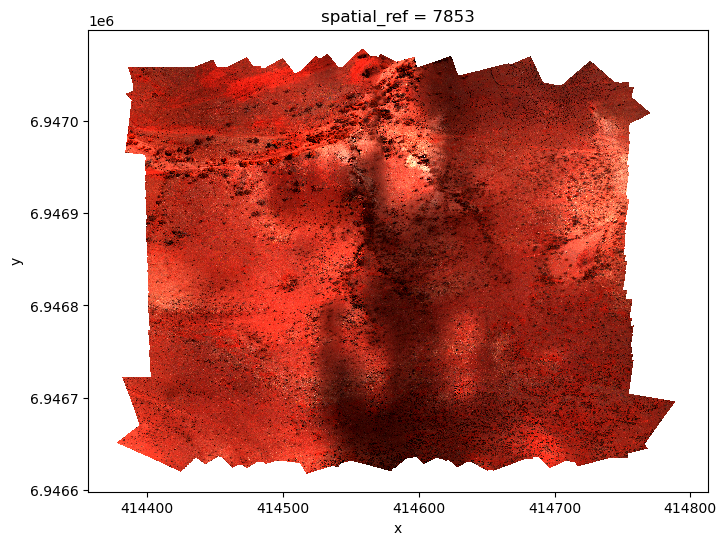

In [4]:
ds[[5, 3, 2]].to_array().plot.imshow(robust=True, size=6);